# Defend leNet5 with convolutional dAE

In [42]:
print(model)

leNet_5 (
  (layer): Sequential (
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): Tanh ()
    (2): AvgPool2d (size=2, stride=2, padding=0, ceil_mode=False, count_include_pad=True)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): Tanh ()
    (5): AvgPool2d (size=2, stride=2, padding=0, ceil_mode=False, count_include_pad=True)
  )
  (fc_layer): Sequential (
    (0): Linear (400 -> 120)
    (1): Tanh ()
    (2): Linear (120 -> 84)
    (3): Tanh ()
    (4): Linear (84 -> 10)
  )
)


In [41]:
print(defense_model)

conv_dAE (
  (encoder): Encoder (
    (conv_layer1): Sequential (
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU (0.01)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
      (3): Dropout (p = 0.02, inplace)
      (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): LeakyReLU (0.01)
      (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
      (7): Dropout (p = 0.02, inplace)
      (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): LeakyReLU (0.01)
      (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (11): Dropout (p = 0.02, inplace)
      (12): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    )
    (conv_layer2): Sequential (
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU (0.01)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
      (3): Dropout (p = 0.02

## LeNet-5

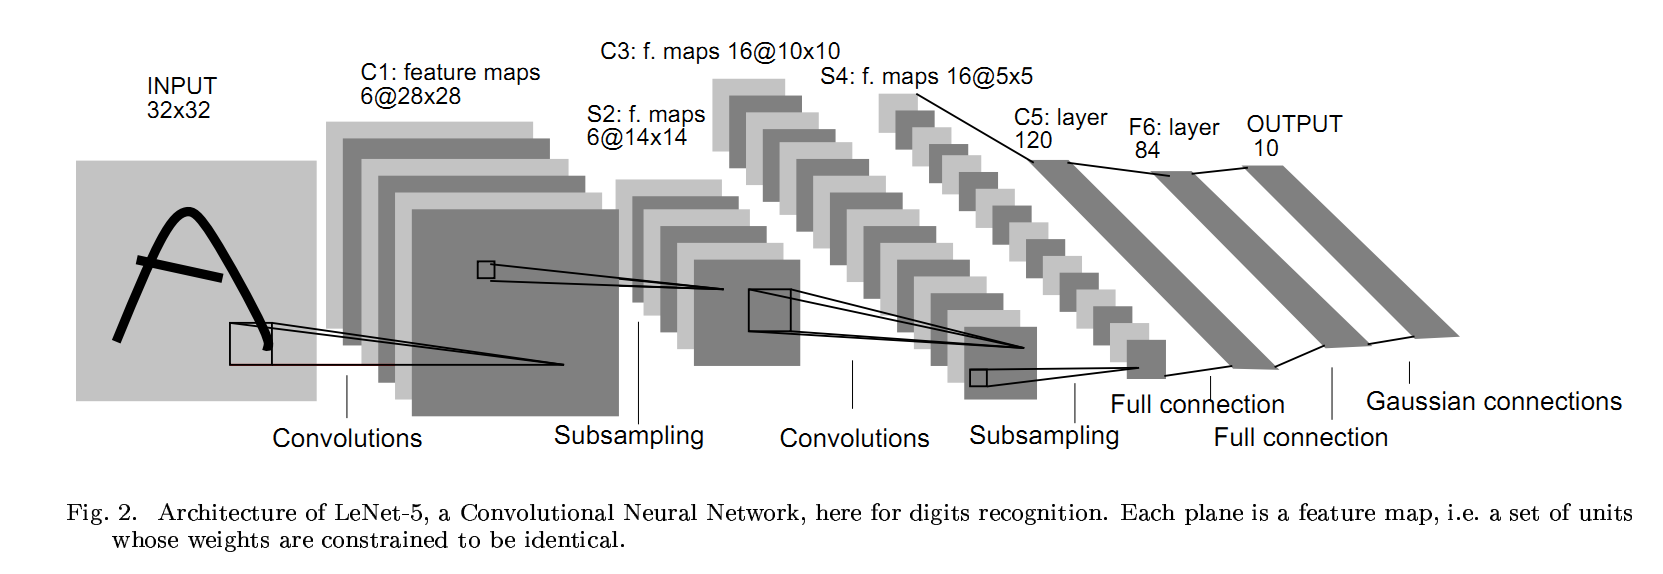

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
% matplotlib inline

## Set Hyperparameter

In [2]:
batch_size=64
learning_rate=0.002
num_epoch=10

## Data preparation

In [3]:
# Download data
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

In [4]:
train_loader=torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True, num_workers=2,drop_last=True)
test_loader=torch.utils.data.DataLoader(mnist_test,batch_size=batch_size,shuffle=False,num_workers=2,drop_last=True)

In [5]:
class leNet_5(nn.Module):
    def __init__(self):
        super(leNet_5,self).__init__()
        
        # 흑백채널: 1 in_channel, 6 feature maps: 6 out_channels
        self.layer=nn.Sequential(
            nn.Conv2d(1,6,5,padding=1,bias=True),
            nn.Tanh(),
            nn.AvgPool2d(2,2),
            nn.Conv2d(6,16,5,padding=1,bias=True),
            nn.Tanh(),
            nn.AvgPool2d(2,2),
        )
        
        self.fc_layer=nn.Sequential(
            nn.Linear(16*5*5,120),
            nn.Tanh(),
            nn.Linear(120,84),
            nn.Tanh(),
            nn.Linear(84,10)
        )
        
    def forward(self,x):
        out=self.layer(x)
        out=out.view(batch_size,-1)
        out=self.fc_layer(out)
        
        return out

In [6]:
model=leNet_5()

# check wether GPU is available
use_gpu = torch.cuda.is_available()
if use_gpu:
    model = model.cuda()
    print ('Use GPU')
else:
    print ('Use CPU')

Use CPU


## Loss function & Optimizer

In [7]:
loss_func=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=learning_rate)

In [8]:
writer = SummaryWriter(comment='test')

## Training

In [9]:
try:
    model = torch.load('./model/lenet5.pkl')
    print("\n================== Model Restored ==================\n")
except:
    print("\n============== No Model to be Restored ==============\n")
    pass


for i in range(num_epoch):
    for batch_idx,[image, label] in enumerate(train_loader):
        n_iter = (i*len(train_loader))+batch_idx
        x=Variable(image)
        y_=Variable(label)
        
        optimizer.zero_grad()
        
        output=model(x)
        
        loss=loss_func(output,y_)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx%1000==0:
            print('Training Epoch: {} \tn_iter: {} \tLoss: {:.6f}'.format(
                i+1, n_iter, loss.data[0]))
            torch.save(model,'./model/lenet5.pkl')
            
        writer.add_scalar('loss',loss.data[0] / len(x),n_iter)
        


============== No Model to be Restored ==============

Training Epoch: 1 	n_iter: 0 	Loss: 2.301022


/anaconda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type leNet_5. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Training Epoch: 2 	n_iter: 937 	Loss: 2.277869
Training Epoch: 3 	n_iter: 1874 	Loss: 2.176490
Training Epoch: 4 	n_iter: 2811 	Loss: 1.817706
Training Epoch: 5 	n_iter: 3748 	Loss: 1.261814
Training Epoch: 6 	n_iter: 4685 	Loss: 1.101151
Training Epoch: 7 	n_iter: 5622 	Loss: 0.709421
Training Epoch: 8 	n_iter: 6559 	Loss: 0.508130
Training Epoch: 9 	n_iter: 7496 	Loss: 0.482055
Training Epoch: 10 	n_iter: 8433 	Loss: 0.531563


# Test

In [10]:
import pickle
from tqdm import *

In [11]:
with open("bulk_mnist_fgsd.pkl", "rb") as f: 
    adv_data_dict = pickle.load(f) 

images = adv_data_dict["xs"]
noises  = adv_data_dict["noises"]
true_labels = adv_data_dict["y_trues"]

## Test with normal test set

In [47]:
i=0
clean_images=[]
clean_labels=[]
clean_batches=[]
for image, noise ,label in tqdm(zip(images, noises,true_labels)):
    
    
    image=torch.from_numpy(image.reshape(28,28))
    image=image.unsqueeze(0)
    image=image.unsqueeze(0)
    
    clean_images.append(image)
    clean_labels.append(label[0])
    
    i+=1
    
    if i%batch_size==0:
        clean_batches.append((torch.cat(clean_images,0),np.array(clean_labels)))
        clean_images=[]
        clean_labels=[]

4817it [00:00, 21434.59it/s]


In [48]:

for image, label in tqdm(clean_batches):
    clean_image=Variable(image,volatile=True)

100%|██████████| 75/75 [00:00<00:00, 149440.76it/s]


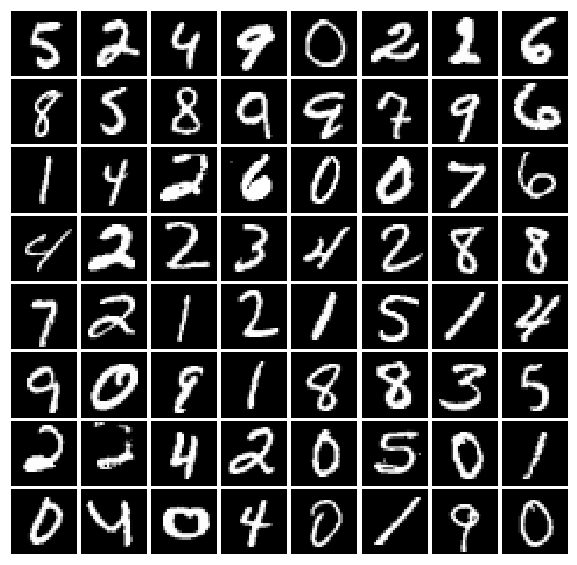

In [59]:
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(8, 8)
gs.update(wspace=0.05, hspace=0.05)
for i in range(64):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(torch.squeeze(clean_image.cpu().data[i]).numpy().reshape(28, 28), cmap='gray')
fig.savefig("raw_MNIST.png")

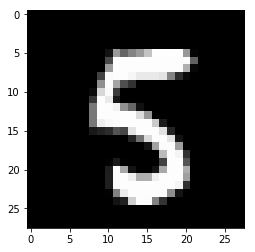

In [62]:
plt.imshow(torch.squeeze(clean_image.cpu().data[0]).numpy().reshape(28, 28), cmap='gray')

In [13]:
correct = 0
total = 0

for image, label in tqdm(clean_batches):
    
    x = Variable(image,volatile=True)
    y_= Variable(torch.from_numpy(np.array(label)))
    
    output = model.forward(x)
    _,output_index = torch.max(output,1)
    
    total += y_.size(0)
    correct += (output_index == y_).sum().float()
    
print("Accuracy for Clean Data: {}".format(100*correct/total))

100%|██████████| 75/75 [00:00<00:00, 106.20it/s]

Accuracy for Clean Data: Variable containing:
 90.8333
[torch.FloatTensor of size 1]



## Test with Adversarial attack set

In [52]:
i=0
noise_images=[]
clean_labels=[]
attack_batches=[]
for image, noise ,label in tqdm(zip(images, noises,true_labels)):
    
    
    image=torch.from_numpy(image.reshape(28,28))
    image=image.unsqueeze(0)
    image=image.unsqueeze(0)
    
    noise=torch.from_numpy(noise.reshape(28,28))
    noise=noise.unsqueeze(0)
    noise=noise.unsqueeze(0)
    
    noise_added=image+noise
    
    noise_images.append(noise_added)
    clean_labels.append(label[0])
    
    i+=1
    
    if i%batch_size==0:
        attack_batches.append((torch.cat(noise_images,0),np.array(clean_labels)))
        noise_images=[]
        clean_labels=[]

4817it [00:00, 32198.73it/s]


In [53]:
correct = 0
total = 0

for image, label in tqdm(attack_batches):
    
    x = Variable(image,volatile=True)
    y_= Variable(torch.from_numpy(np.array(label)))
    
    output = model.forward(x)
    _,output_index = torch.max(output,1)
    
    total += y_.size(0)
    correct += (output_index == y_).sum().float()
    
print("Accuracy for Adversarial Attack Data: {}".format(100*correct/total))

100%|██████████| 75/75 [00:00<00:00, 105.74it/s]

Accuracy for Adversarial Attack Data: Variable containing:
 64.4375
[torch.FloatTensor of size 1]



# Defense model: conv_dAE (1 epoch training)

In [27]:
d_learning_rate=0.003
d_num_epoch=2
leak=0.05
drop_rate=0.02
noise_level=1

### Encoder

In [17]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        
        # output size = (image_width - kernel_width)/stride +1
        
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size,
        #                 stride=1, padding=0, dilation=1,
        #                 groups=1, bias=True)

        
        self.conv_layer1 = nn.Sequential(
                        nn.Conv2d(1,16,3,padding=1),
                        nn.LeakyReLU(leak),
                        nn.BatchNorm2d(16),
                        nn.Dropout(p=drop_rate,inplace=True),
                        # batch_size*  28*28  *16 featuremaps
            
                        nn.Conv2d(16,32,3,padding=1), 
                        nn.LeakyReLU(leak),
                        nn.BatchNorm2d(32),
                        nn.Dropout(p=drop_rate,inplace=True),
                        # batch_size*  28*28  *16 featuremaps
                
                        nn.Conv2d(32,64,3, padding=1),  
                        nn.LeakyReLU(leak),
                        nn.BatchNorm2d(64),
                        nn.Dropout(p=drop_rate,inplace=True),
                        nn.MaxPool2d(2,2)
                        # batch_size*  14*14  *64 featuremaps
            
        )
        
        self.conv_layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1), 
                        nn.LeakyReLU(leak),
                        nn.BatchNorm2d(128),
                        nn.Dropout(p=drop_rate,inplace=True),
                        nn.MaxPool2d(2,2),
                        # batch_size*  7*7  *128 featuremaps
                
                        nn.Conv2d(128,256,3,padding=1),  
                        nn.LeakyReLU(leak)
                        # batch_size*  7*7  *256 featuremaps
        )
   
        
    def forward(self,x):
        out=self.conv_layer1(x)
        out=self.conv_layer2(out)
        out=out.view(batch_size,-1)
        
        return out

### Decoder
* input: small feature maps
* output: reconstructed image

In [18]:
# torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, 
#   output_padding=0, groups=1, bias=True, dilation=1)

# H_out=(H_in−1)∗stride(4th) + kernel_size(3rd) − 2∗padding(5th) + output_padding

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        
        
        self.transConv_layer1 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,3,2,1,1),
                        nn.LeakyReLU(leak),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,1),
                        nn.LeakyReLU(leak),
                        nn.BatchNorm2d(64)
        )
        self.transConv_layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,16,3,1,1),
                        nn.LeakyReLU(leak),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,1,3,2,1,1),
                        nn.ReLU()
        )
        
       
    def forward(self,x):
        x = x.view(batch_size,256,7,7)
        out = self.transConv_layer1(x)
        out = self.transConv_layer2(out)
        
        return out

### the Model as a whole
* encoder & decoder

In [19]:
class conv_dAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(conv_dAE,self).__init__()
        
        self.encoder=encoder
        self.decoder=decoder
            
    def forward(self,x):
        
        out=self.encoder(x)
        out=self.decoder(out)

        return out

In [20]:
defense_model=conv_dAE(Encoder(),Decoder())

In [21]:
def add_noise(x,noise_level):
    noise=noise_level*init.normal(torch.FloatTensor(batch_size,1,28,28),0,0.1)
    noise=Variable(noise)
    result=x+noise

    return result

In [22]:
defense_loss_func=nn.MSELoss()

In [23]:
defense_optimizer=optim.Adam(defense_model.parameters(),lr=d_learning_rate)

In [25]:
try:
    defense_model = torch.load('./model/conv_dAE.pkl')
    print("\n=================== Model Restored ===================\n")
except:
    print("\n=============== No Model to be Restored ===============\n")
    pass


=================== Model Restored ===================



In [54]:
i=0
for image, label in tqdm(attack_batches):
    attack_image=Variable(image,volatile=True)
#     noise_added_image=add_noise(image,noise_level)
    
    denoised_output=defense_model(attack_image)
    
    loss=defense_loss_func(denoised_output,attack_image)
    
    i+=1
    if i % 20==0:
        print('n_iter: {} \tLoss: {:.6f}'.format(
                i+1, loss.data[0]))

 27%|██▋       | 20/75 [00:05<00:15,  3.48it/s]

n_iter: 21 	Loss: 0.006358


 53%|█████▎    | 40/75 [00:11<00:10,  3.42it/s]

n_iter: 41 	Loss: 0.006229


 80%|████████  | 60/75 [00:18<00:04,  3.29it/s]

n_iter: 61 	Loss: 0.006292


100%|██████████| 75/75 [00:22<00:00,  3.26it/s]


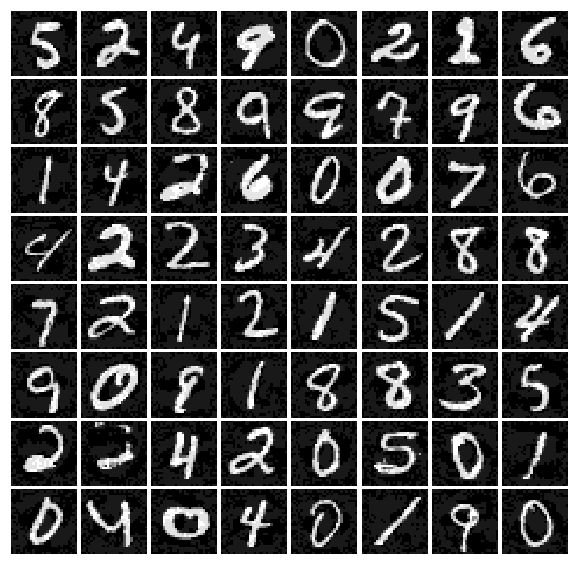

In [60]:
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(8, 8)
gs.update(wspace=0.05, hspace=0.05)
for i in range(64):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(torch.squeeze(attack_image.cpu().data[i]).numpy().reshape(28, 28), cmap='gray')
fig.savefig("attack_images_before_dAE.png")

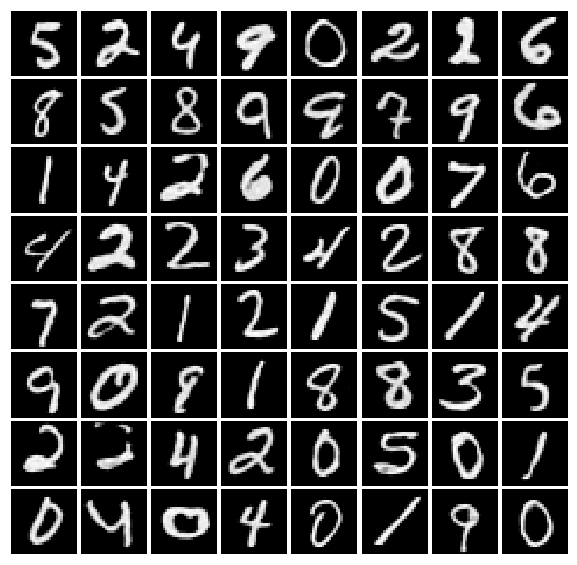

In [57]:
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(8, 8)
gs.update(wspace=0.05, hspace=0.05)
for i in range(64):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(denoised_output[i].data.numpy().reshape(28, 28), cmap='gray')
fig.savefig("cleansed_attack_images_by_{}epochs_conv_dAE.png".format(d_num_epoch))

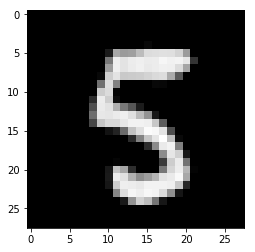

In [63]:
plt.imshow(denoised_output[0].data.numpy().reshape(28, 28), cmap='gray')

# Run through the whole model

In [39]:
i=0
for image, label in tqdm(attack_batches):
    attack_image=Variable(image,volatile=True)
    y_= Variable(torch.from_numpy(np.array(label)))
#     noise_added_image=add_noise(image,noise_level)
    
    denoised_output=defense_model(attack_image)
    
    output=model(denoised_output)

    _,output_index = torch.max(output,1)
    
    total += y_.size(0)
    correct += (output_index == y_).sum().float()
    
print("Accuracy for Attack Data after purification: {}".format(100*correct/total))

100%|██████████| 75/75 [00:23<00:00,  3.13it/s]

Accuracy for Attack Data: Variable containing:
 75.2812
[torch.FloatTensor of size 1]

